# Import libraries

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import os

# Parameter Dataset

In [ ]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

train_dir = "/content/drive/MyDrive/Dataset/Blackmold/train"
val_dir = "/content/drive/MyDrive/Dataset/Blackmold/valid"

# Augmentation

In [ ]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode='binary'
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode='binary'
)

class_names = train_ds.class_names
print("Label klasifikasi:", class_names)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

Found 7557 files belonging to 2 classes.
Found 2968 files belonging to 2 classes.
Label klasifikasi: ['0_nonblackmold', '1_blackmold']


# Class Imbalance Check

In [ ]:
def count_class_distribution(dataset):
    class_count = {0: 0, 1: 0}
    for _, labels in dataset:
        for label in labels.numpy():
            class_count[int(label)] += 1
    return class_count

train_counts = count_class_distribution(train_ds)
total = train_counts[0] + train_counts[1]
class_weight = {
    0: total / (2.0 * train_counts[0]),
    1: total / (2.0 * train_counts[1])
}

print("Distribusi kelas:", train_counts)
print("Class weight:", class_weight)

/tmp/ipython-input-6-3660896709.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  class_count[int(label)] += 1
/tmp/ipython-input-6-3660896709.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  class_count[int(label)] += 1
/tmp/ipython-input-6-3660896709.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  class_count[int(label)] += 1
/tmp/ipython-input-6-3660896709.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will

Distribusi kelas: {0: 1455, 1: 6102}
Class weight: {0: 2.5969072164948455, 1: 0.6192232055063913}


/tmp/ipython-input-6-3660896709.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  class_count[int(label)] += 1


# Modelling

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False

model = keras.Sequential([
    data_augmentation,
    tf.keras.layers.Rescaling(1./255),
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.build(input_shape=(None, IMG_HEIGHT, IMG_WIDTH, 3))
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

# Training Model

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    class_weight=class_weight
)

Epoch 1/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 905s 4s/step - accuracy: 0.8001 - loss: 0.4254 - val_accuracy: 0.8160 - val_loss: 0.4328
Epoch 2/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 551s 2s/step - accuracy: 0.9003 - loss: 0.2259 - val_accuracy: 0.8693 - val_loss: 0.3634
Epoch 3/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 559s 2s/step - accuracy: 0.9244 - loss: 0.1722 - val_accuracy: 0.8403 - val_loss: 0.5055
Epoch 4/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 540s 2s/step - accuracy: 0.9403 - loss: 0.1363 - val_accuracy: 0.8534 - val_loss: 0.4371
Epoch 5/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 539s 2s/step - accuracy: 0.9522 - loss: 0.1188 - val_accuracy: 0.8861 - val_loss: 0.3672
Epoch 6/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 569s 2s/step - accuracy: 0.9600 - loss: 0.1003 - val_accuracy: 0.8427 - val_loss: 0.4787
Epoch 7/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 530s 2s/step - accuracy: 0.9672 - loss: 0.0817 - val_accuracy: 0.8177 - val_loss: 0.6328
Epoch 8/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 558s 2s/step - accuracy: 0.9588 - loss: 0.0952 - val_accu

# Evaluation

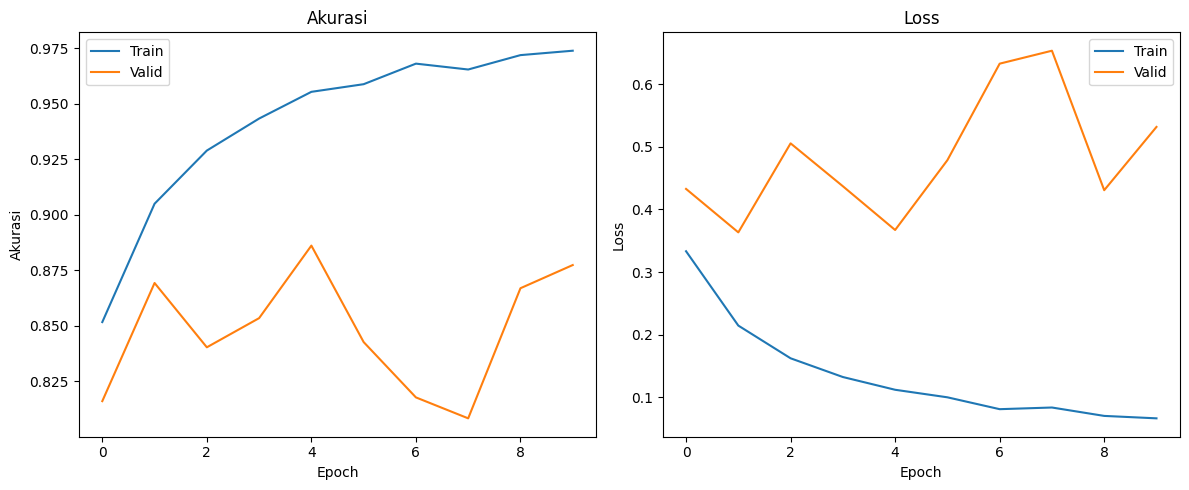

In [ ]:
plt.figure(figsize=(12, 5))

# Akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Valid')
plt.title('Akurasi')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Valid')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Ambil prediksi dan label
y_true = []
y_pred = []
for images, labels in val_ds:
    preds = model.predict(images)
    y_pred.extend([1 if p > 0.5 else 0 for p in preds])
    y_true.extend(labels.numpy().astype(int))

print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=class_names))


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 

# Prediction

Saving 1-hairline-crack-wall_jpg.rf.082fa7cfd405c33915ba98477fa48858 - Copy (3).jpg to 1-hairline-crack-wall_jpg.rf.082fa7cfd405c33915ba98477fa48858 - Copy (3).jpg

🔍 Memproses: 1-hairline-crack-wall_jpg.rf.082fa7cfd405c33915ba98477fa48858 - Copy (3).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


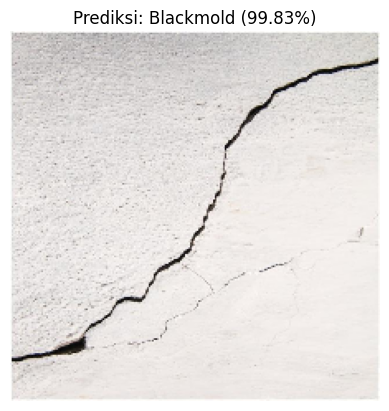

Hasil Prediksi: Blackmold (99.83%)


In [ ]:
from google.colab import files
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np

def predict_image(model, img_path):
    img = image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    prediction = model.predict(img_array)[0][0]
    percentage = prediction * 100

    pred_label = 'Blackmold' if prediction > 0.5 else 'Bukan blackmold'

    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prediksi: {pred_label} ({percentage:.2f}%)")
    plt.show()

    return pred_label, percentage

# Upload file dari komputermu
uploaded = files.upload()

for filename in uploaded.keys():
    print(f"\n🔍 Memproses: {filename}")
    pred_label, percentage = predict_image(model, filename)
    print(f"Hasil Prediksi: {'Blackmold' if percentage > 50 else 'Tidak Teridentifikasi'} ({percentage:.2f}%)")

# Save Model

In [ ]:
model.save("blackmold_cnn_model.keras")

# Convert to TFLite

In [ ]:
model = tf.keras.models.load_model("blackmold_cnn_model.keras")

# Buat converter dari model SavedModel
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Optional: optimasi agar ukuran file lebih kecil dan cocok untuk mobile
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Konversi model
tflite_model = converter.convert()

# Simpan file .tflite
with open("blackmold_detector.tflite", "wb") as f:
    f.write(tflite_model)

print("✅ Model berhasil dikonversi ke blackmold_detector.tflite")

Saved artifact at '/tmp/tmp272pcxny'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  136575300896336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136575300895184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136575300894800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136575300897104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136575300895760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136575300895568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136575300898640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136575300899024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136575300898832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136575300894992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1365753009001